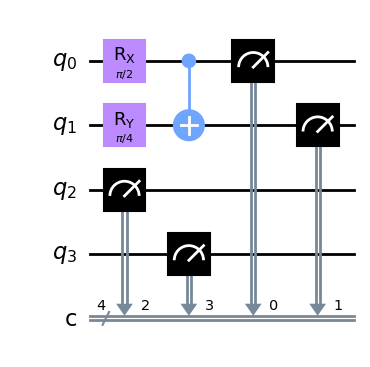

In [190]:
import pennylane as qml
from pennylane_qiskit import AerDevice
import numpy as np

# Define the number of qubits and PennyLane device
dev = qml.device("qiskit.aer", wires=4)

# Create a PennyLane quantum circuit
@qml.qnode(dev)
def my_quantum_circuit(parameters):
    qml.RX(parameters[0], wires=0)
    qml.RY(parameters[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))


# Define circuit parameters
parameters = np.array([np.pi/2, np.pi/4])

# add the my_quantum_circuit function to the device queue and print the circuit
my_quantum_circuit(parameters)

# Draw the Qiskit circuit
dev._circuit.draw(output='mpl')

In [191]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
# Plotting
import matplotlib.pyplot as plt

In [192]:
n_qubits = 3  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
steps = 30  # Number of optimization steps
eta = 0.8  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 0  # Seed for random number generator

In [195]:
q = QuantumRegister(n_qubits+1, name='q')
c = ClassicalRegister(n_qubits+1, name='c')
qc = QuantumCircuit(q, c)
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([1.0, 0.2, 0.2])

# create a quantum circuit

def U_b(qc: QuantumCircuit):
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for i in range(n_qubits):
        qc.h(q[i])

def CA(qc: QuantumCircuit, index: int):
    """Controlled versions of the unitary components A_l of the problem matrix A."""    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if index == 0:
        return
    elif index == 1:
        qc.cx(q[ancilla_idx], q[0])
        qc.cz(q[ancilla_idx], q[1])
    elif index == 2:
        qc.cx(q[ancilla_idx], q[0])

def VariationalBlock(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    # We first prepare an equal superposition of all the states of the computational basis.
    for i in range(n_qubits):
        qc.h(q[i])

    # A very minimal variational circuit.
    for ind,value in enumerate(weights):
        qc.ry(value, q[ind])

def localHadamardTest(qc:QuantumCircuit, weights, l=None,lp=None, j=None, part=None):
    # First Hadamard gate applied to the ancillary qubit.
    qc.h(q[ancilla_idx])

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qc.p(-np.pi/2, q[ancilla_idx])
    
    # Variational circuit generating a guess for the solution vector |x>
    VariationalBlock(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(qc, l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    U_b(qc)

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qc.cz(q[ancilla_idx], q[j])

    # Unitary U_b associated to the problem vector |b>.
    U_b(qc)

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(qc, lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qc.h(q[ancilla_idx])


def mu(qc:QuantumCircuit, weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""
    mu_real = localHadamardTest(qc,weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = localHadamardTest(qc,weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

def psi_norm(qc:QuantumCircuit, weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(qc, weights, l, lp, -1)

    return abs(norm)

def cost_loc(qc:QuantumCircuit,weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(qc,weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(qc,weights))

import autograd.numpy as np
from autograd import grad

def gradientDescent(qc:QuantumCircuit,weights, eta, steps):
    """Gradient descent algorithm with learning rate eta."""
    cost = np.zeros(steps)
    weights_tmp = np.zeros((steps, len(weights)))

    for i in range(steps):
        weights_tmp[i] = weights
        cost[i] = cost_loc(qc, weights)
        print("Step = {:4d},  Cost = {: .7f}".format(i, cost[i]))

        for j in range(len(weights)):
            weights[j] = weights[j] - eta * grad(cost_loc)(weights)[j]

        for j in range(len(weights)):
            weights[j] = weights[j] - eta * grad(cost_loc)(weights)[j]

    return weights, cost, weights_tmp

localHadamardTest(qc, [np.pi/2, np.pi/4, np.pi/8], l=1, lp=2, j=0, part="Re")
qc.draw(output='mpl')

gradientDescent(qc,[np.pi/2, np.pi/4, np.pi/8], eta, steps)

TypeError: unsupported operand type(s) for *: 'complex' and 'NoneType'

In [ ]:

# Create a PennyLane quantum circuit
def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        qml.CNOT(wires=[ancilla_idx, 0])
        qml.CZ(wires=[ancilla_idx, 1])

    elif idx == 2:
        qml.CNOT(wires=[ancilla_idx, 0])

In [ ]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)


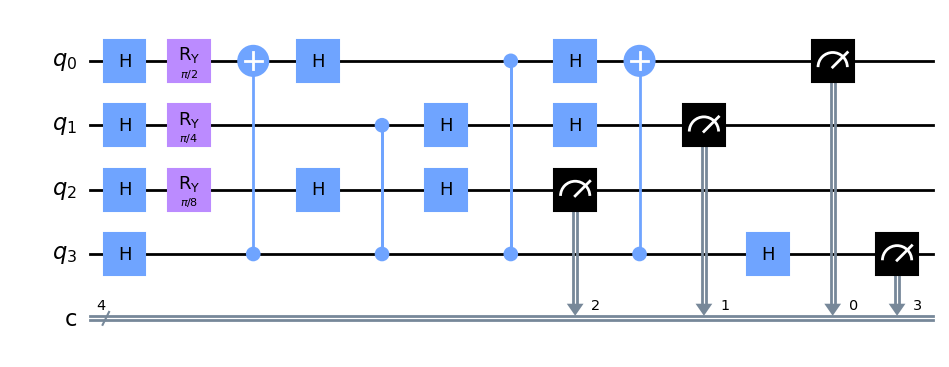

In [ ]:
dev_mu = qml.device("qiskit.aer", wires=tot_qubits)

@qml.qnode(dev_mu, interface="autograd")
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

#print 
weights = [np.pi/2, np.pi/4, np.pi/8]
local_hadamard_test(weights, l=1, lp=2, j=0, part="Re")
dev_mu._circuit.draw(output='mpl')